## Causal Inference and Experimental Design

How many times have you heard this uttered in response to some new statistical claim: "correlation is not causation".  While this is of course an important concept to keep in mind, by embracing it too readily you risk embracing a certain scientific nihilism.  In this notebook, we'll talk about a few ways to extricate ourselves from this bind.

### Electromagnetic Field Exposure and Cancer

We'll be using the problem of inferring whether or not electromagnetic field exposure causes poor health as a running example throughout this notebook.  To get started, we'll introduce the concept of a probabilistic graphical model.  The model uses the formalism of a graph to specify the probabilistic structure among a set of random variables.  For instance, here is a probabilistic graphical model that formalizes the relationship between EMF exposure and health.

Installed gvmagic.py. To use it, type:
  %load_ext gvmagic
The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


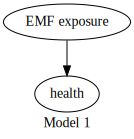

In [41]:
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py
%load_ext gvmagic
%dotstr 'digraph { label="Model 1" ; "EMF exposure" -> health }'

While not always the case, in this example we will interpret the arrows as indicating a direction of causality.  That is, in the preceding example EMF exposure causes health (or lack thereof).  Another option is that health causes EMF exposure.

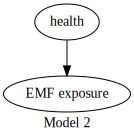

In [2]:
%dotstr 'digraph { label="Model 2" ; health -> "EMF exposure" }'

Yet another option is that there is no causal relationship at all between EMF exposure and health.  This is indicated by removing the arrow connecting the two nodes.

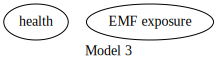

In [42]:
%dotstr 'digraph { label="Model 3" ; health ; "EMF exposure" }'

Suppose we want to design an experiment to determine which of these three models is correct.  For now we'll assume that we can poll a random collection of 100 people and ask them to answer two questions: what level of exposure to EMF exposure have you had in your lifetime (let's pretend people can actually answer this question), and how healthy are you?

We now want to draw conclusions about which of the potential graphical models is consistent with the data.  In order to answer this question, we have to know a little bit about the implications of the graphical structure on the independence relationships in the data.

First, if two nodes are disconnected then it implies that they are independent of each other.  For instance, in the example where EMF exposure and health are not connected, this implies that $p(health, EMF~exposure) = p(health)p(EMF~exposure)$ for all possible values of health and EMF exposure (in this case we can think of them each as continuous scalar quantities).  For each of the two other models it is not necessarily the case that $p(health, EMF~exposure) = p(health)p(EMF~exposure)$.  In fact, if the two quantities are equal, then we can take that as evidence that there is no arrow connecting the two nodes.  This conclusion is an appeal to a philosophical principal of simplicity that has been stated in a number of forms (e.g. Occam's razor).  Thomas Aquinas perhaps said it best.

> "it is superfluous to suppose that what can be accounted for by a few principles has been produced by many"

Therefore, we can use the relationship $p(health, EMF~exposure) = p(health)p(EMF~exposure)$ as a means of distinguishing between model 3 and models 1 and 2.  If the equation holds, that is evidence for model 3.  If the equation does not hold, that is evidence for model 1 or model 2.  Unfortunately, models 1 and 2 offer no way to distinguish between them.  Given our simplistic experimental design, there is no way that we can determine whether EMF exposure causes health or health causes EMF exposure.  Let's see if we can at least get rid of model 3.

If two random variables are indepedendent, then they are necessarily uncorrelated.  We can test for correlation between our two random variables as a means of determining whether or not it is plausible that they are independent.  If the two variables are correlated, then they cannot be independent, and we can throw out model 3.  Suppose we collect the following data.

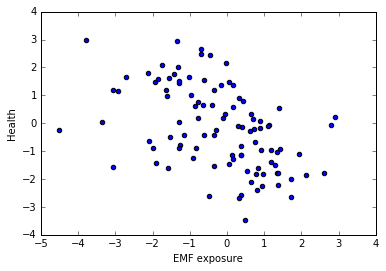

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from emf_cancer_data import data
plt.scatter(data.EMF_exposure, data.health)
plt.xlabel('EMF exposure')
plt.ylabel('Health');

We can use a hypothesis test (in this case a t-test) to determine whether the two variables are correlated.

In [39]:
from scipy.stats import pearsonr

r, p_val = pearsonr(data.EMF_exposure, data.health)
print "Pearson correlation (R): {}, p-value {}".format(r, p_val)

Pearson correlation (R): -0.465536539122, p-value 1.05823208769e-06


How can we interpret this result?  What does it say about the possible causal structure in the data?  What other analysis might you want to do?

### Hidden Causes

The elimination of model 3 is only valid under the assumption that there is no unobserved common cause for both health and EMF exposure.  For instance, let's propose a fourth model to explain the data.

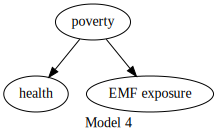

In [43]:
%dotstr 'digraph { label="Model 4" ; poverty -> health ; poverty -> "EMF exposure" }'

Perhaps the reason that $p(health, EMF~exposure) \neq p(health) p(EMF~exposure)$ is that there is an underlying common cause that causes the variables to be correlated.  This seems very unfortunate.  We appear to have failed to even narrow down our seach to model 1 or model 2!  Luckily, we can do another analysis that can potentially eliminate model 4.  This analysis is called a partial correlation.

### Partial Correlation

Partial correlations are actually quite easy to understand given the tools we've learned up until now.  If we compute the partial correlation of variables X and Y after controlling for Z, we are attempting to determine if a correlation still exists between X and Y after the effects of Z on both X and Y have been removed.  To better understand this, let's look at some plots.

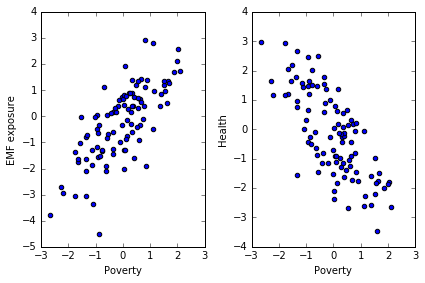

In [44]:
plt.subplot(121)
plt.scatter(data.poverty, data.EMF_exposure)
plt.xlabel('Poverty')
plt.ylabel('EMF exposure')
plt.subplot(122)
plt.scatter(data.poverty, data.health)
plt.xlabel('Poverty')
plt.ylabel('Health')
plt.tight_layout()

There are clear linear relationships between each of our original variables and poverty.  In order to see if EMF exposure and health are still correlated after controlling for poverty, we can perform two linear regressions: one from poverty to EMF exposure and one from poverty to health.  We can then determine if the residuals from these two regressions are related.

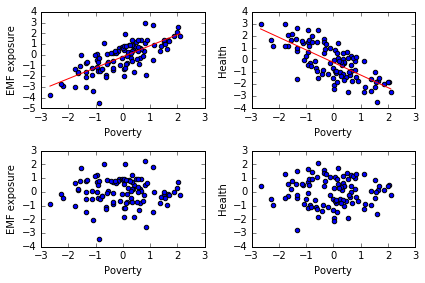

In [45]:
from sklearn.linear_model import LinearRegression
import numpy as np

control = data.poverty[:,np.newaxis]

model_EMF = LinearRegression().fit(control, data.EMF_exposure)
model_health = LinearRegression().fit(control, data.health)

plt.subplot(221)
plt.scatter(data.poverty, data.EMF_exposure)
# line of best fit
plt.plot([data.poverty.min(), data.poverty.max()],
         [data.poverty.min()*model_EMF.coef_ + model_EMF.intercept_,
          data.poverty.max()*model_EMF.coef_ + model_EMF.intercept_],
         'r')
plt.xlabel('Poverty')
plt.ylabel('EMF exposure')
plt.subplot(222)
plt.scatter(data.poverty, data.health)
# line of best fit
plt.plot([data.poverty.min(), data.poverty.max()],
         [data.poverty.min()*model_health.coef_ + model_health.intercept_,
          data.poverty.max()*model_health.coef_ + model_health.intercept_],
         'r')
plt.xlabel('Poverty')
plt.ylabel('Health')

plt.subplot(223)
# plot residuals
plt.scatter(data.poverty, data.EMF_exposure - model_EMF.predict(control))
plt.xlabel('Poverty')
plt.ylabel('EMF exposure')

plt.subplot(224)
# plot residuals
plt.scatter(data.poverty, data.health - model_health.predict(control))
plt.xlabel('Poverty')
plt.ylabel('Health')

plt.tight_layout()

As expected, the residuals are uncorrelated with the control variable poverty.  This is an inevitable consequence of performing a linear regression.  However, the interesting thing is determining whether or not the residuals in the bottom two plots are correlated with each other.

Pearson correlation (R): 0.163657122758, p-value 0.103740261852


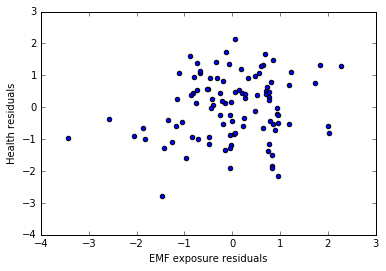

In [46]:
plt.scatter(data.EMF_exposure - model_EMF.predict(control),
            data.health - model_health.predict(control))

# now compute the correlation of the residuals
r, p_val = pearsonr(data.EMF_exposure - model_EMF.predict(control),
                    data.health - model_health.predict(control))
plt.xlabel('EMF exposure residuals')
plt.ylabel('Health residuals')
print "Pearson correlation (R): {}, p-value {}".format(r, p_val)

The correlation we computed is known as a [partial correlation](https://en.wikipedia.org/wiki/Partial_correlation).  As a side note, partial correlations work equally well when one has multiple control variables.  The procedure we just went through is a bit cumbersome.  Unfortunately, I was not able to find any standard implementations (by standard I mean in scipy, scikit-learn, numpy, etc.) of this in Python.  There were plenty of user contributed implementations that you can dig up if you'd like to use this.  Here is [one](https://gist.github.com/fabianp/9396204419c7b638d38f) that I found.

What conclusions can we draw from this new analysis?  What does it say about the four possible causal models that we identified?

### Simpson's Paradox

The phenomena we observed above can be even more extreme.  When controlling for a potential confounding variable, instead of merely removing a previously observed correlation, the correlation could actually reverse itself.  This is one example of something called Simpson's Paradox.  Check out the [Wikipedia page](https://en.wikipedia.org/wiki/Simpson's_paradox) on this topic.

### Markov Equivalence

All of the analysis we have done up until now has been centered around the idea of distinguishing between causal models by gathering evidence either for, or against, various probabilistic dependencies between variables.  However, as we said at the beginning, there are causal models that differ in structure that do not differ in the probabilistic dependencies they predict.  For instance, model 1 and model 2 that showed above make exactly the same predictions.  If our partial correlation had shown that there was in fact a link between the two variables, then we would not have been able to rule out model 1 versus model 2.

We can formalize this problem by using a property known as Markov equivalence.  Two causal models are Markov equivalent if they make exactly the same predictions regarding probabalistic dependencies between variables.  Methods for determining whether two models are Markov equivalent were originally presented [here](https://projecteuclid.org/download/pdf_1/euclid.aos/1031833662).  A detailed presentation of the procedures used to determine Markov equivalence is outside the scope of this class.

### Methods of Inferring Causation

It looks like all hope is lost, what are some methods that we could use to figure out true causal structure from data?  Take some time to discuss this at your tables and then we'll get back together to synthesize as a group. You don't necessarily have to limit yourself to our running example on the link between EMF exposure and health.

## Further Reading

### Causal Calculus

Here is a [great post](http://www.michaelnielsen.org/ddi/if-correlation-doesnt-imply-causation-then-what-does/) that touches upon some of the properties of Markov equivalence, and talks about some of Judea Pearl's work on causal calculus.  The post is in a somewhat incomplete state, but there are some pretty interesting things in there.